In [ ]:
import numpy as np
import matplotlib.pyplot as plt

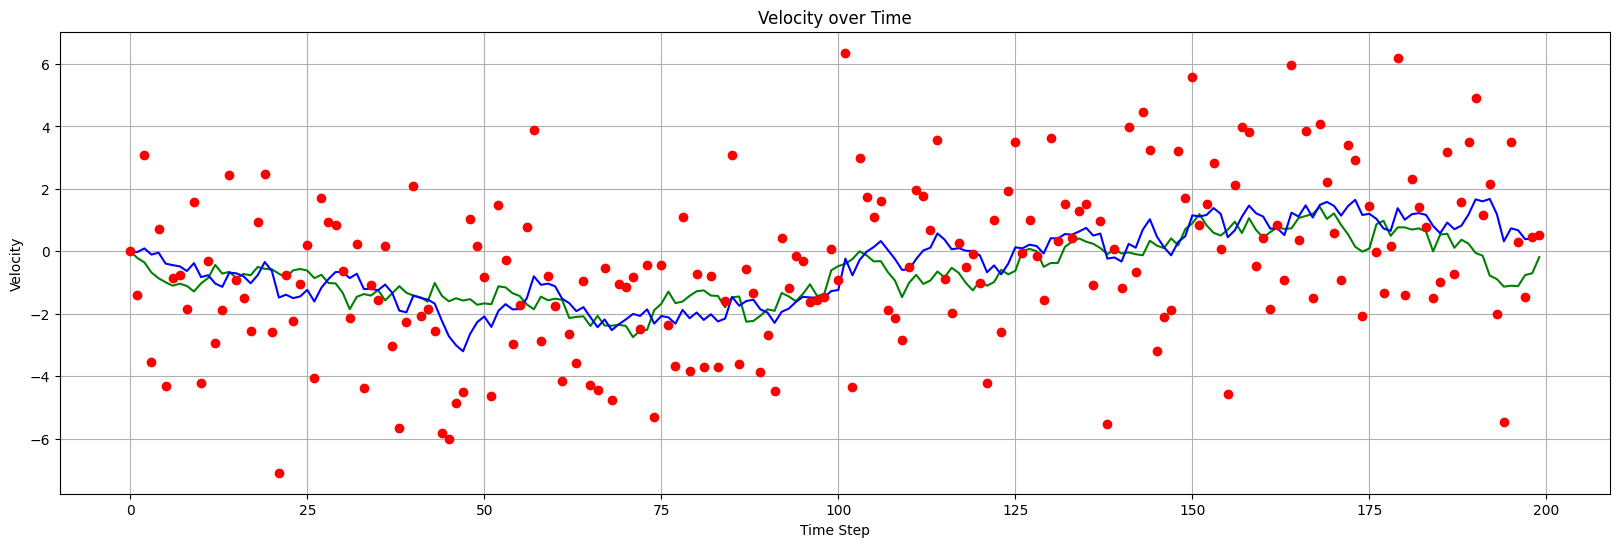

In [ ]:
y = np.array([[0]]) #measured vel
x = np.array([[0, 0]]).T #pos, vel
u = np.array([[0]]) #acc
ε = np.array([[0, 0], #x covarance
             [0, 0]])

W = np.array([[.1, 0], #covaraince for dynamics uncertainty
             [0, .1]])
V = np.array([[5]]) #covaraince for measurement noise
meanVectorW = np.zeros(W.shape[0]) #mean for W
meanVectorV = np.zeros(V.shape[0]) #mean for V

C = np.array([[0, 1]]) #transform data to measurment c@x + noise = z where z is measurements from IMU, etc

#physics
dt = 0.05
A = np.array([[1, dt], #df/dx
              [0, 1]])
B = np.array([[0.5*dt**2], #df/du
              [dt]])

time = 10 #seconds
steps = int(time/dt) #total timesteps (1/dt = Hz)

#dynamics of the system. isRandom is true for the actual trajectory. For prediction isRandom is false
def dynamics(_x, _u, isRandom):
  if (isRandom):
    return A@_x + B@_u + np.array([np.random.multivariate_normal(meanVectorW, W)]).T
  else:
    return A@_x + B@_u

#gets the velocity from the "measurment". Actually gets it from the state and then adds extra noise to simulate the measurement
def getVelocity(_x):
  return C@_x + np.array([np.random.multivariate_normal(meanVectorV, V)])

#sample U's for the trajcetory
allU = np.random.normal(loc=0, scale=.1, size=(steps-1, u.shape[0], u.shape[1]))

#getting the actual trajectory
xReal = np.zeros((steps, x.shape[0], x.shape[1]))
xReal[0] = x
for i in range(1, steps):
  xReal[i] = dynamics(xReal[i-1], allU[i-1], True)

mean = np.zeros((steps, x.shape[0], x.shape[1])) #storing all the means to graph
covariance = np.zeros((steps, ε.shape[0], ε.shape[0])) #storing all the covarainces because why not
measurments = np.zeros((steps, y.shape[0], y.shape[1]))

#get Estimate Pos using linear Kalmin Filter
mean[0] = x
covariance[0] = ε
measurments[0] = y

for i in range(1, steps):
  #predict mean of X, covarance
  mean[i] = dynamics(mean[i-1], allU[i-1], False)
  covariance[i] = A@covariance[i-1]@A.T + W

  #Calculate Innovations
  measurments[i] = getVelocity(xReal[i])
  z = measurments[i] - C@mean[i] #measurement - predicted measurement
  S = C@covariance[i]@C.T + V

  #calculate Kalman Gain (L)
  L = covariance[i]@C.T@np.linalg.inv(S)

  #Update mean of X, covarance
  mean[i] = mean[i] + L@z
  LandC = L@C
  covariance[i] = (np.eye(LandC.shape[0], dtype=int) - LandC)@covariance[i]@((np.eye(LandC.shape[0], dtype=int) - LandC).T) + L@V@(L.T)


# Plot the real velocity/input over time
plt.figure(figsize=(20, 6))
plt.plot(xReal[:, 1, 0], linestyle='-', color='g') #xReal[:, 0, 0] is xVel over time (green)
plt.plot(mean[:, 1, 0], linestyle='-', color='b') #mean[:, 0, 0] is mean (of velocity) over time (blue)
plt.plot(measurments[:, 0, 0], marker='o', linestyle='none', color='r') #measurments[:, 0, 0] is the measurments from the noisy device over time of velocity (red)
plt.title('Velocity over Time')
plt.xlabel('Time Step')
plt.ylabel('Velocity')
plt.grid(True)
plt.show()

